# 1 Modelling the external data
## Case a) Theoretical EV amplitude

**Author:** Hannu Parviainen<br>
**Last edited:** 26.5.2022

The *external data analysis* models the prior KELT-1b light curves (TESS, Ks, H, and Spitzer 3.6 and 4.5 $\mu$m) jointly usinga a phase curve model that includes a transit, secondary eclipse, thermal emission, ellipsoidal variation, and Doppler boosting. We ignore the reflection signal for now since it is too degenerate with thermal emission, but we can study the possible ranges for emission and reflection later.

The model is implemented by `src.externaldatalpf.ExternalDataLPF`, which inherits all its functionality from `pytransit.lpf.PhaseCurveLPF`.

This first case sets theoretical priors on the ellipsoidal variation (EV) amplitude. The EV amplitude is wavelength dependent, increases from red to blue, and has been calculated for our passbands in the [ellipsoidal variation](A1_ellipsoidal_variation.ipynb) notebook.

The model uses individual GPs for each light curve to model the systematics. This makes the likelihood quite expensive to calculate, so it's best to parallelise the optimisation and sampling. We do this using multiprocessing, but for this we need to force the separate processes to use a single thread (for example, the transit model evaluation in *PyTransit* is already multithreaded, and running many processes each with many threads would slow down the computations rather than speeding them.)

In [1]:
%run src/init_threading_for_multiprocessing.py

In [ ]:
%matplotlib inline

In [2]:
from multiprocessing import Pool
from numpy.random import permutation
from src import ExternalDataLPF, read_mcmc

## Initialise the LPF

In [3]:
lpf = ExternalDataLPF('a')

## Take a look at the parameters and their priors

In [6]:
lpf.ps

[  0 |G| tc             N(μ = 2455914.1628, σ = 0.01)            [    -inf ..      inf],
   1 |G| p              N(μ = 1.217513, σ = 4.5e-05)             [    0.00 ..      inf],
   2 |G| rho            N(μ = 0.5392592032228568, σ = 0.07529312598667542) [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |G| secw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   6 |P| k2             N(μ = 0.078, σ = 0.005)                  [    0.00 ..      inf],
   7 |G| oev            N(μ = 0.0, σ = 0.09)                     [    -inf ..      inf],
   8 |G| aev_TESS       N(μ = 0.000443, σ = 2.8e-05)             [    0.00 ..      inf],
   9 |G| adb_TESS       N(μ = 4.1e-05, σ = 4.2e-06)              [    0.00 ..      inf],
  10 |G| log10_ted_TESS U(a = -3.0, b = 0.0)                     [    -inf ..      inf],
  11 |G| lo

## Set up the multiprocessing pool

The log posterior function is quite heavy to compute and we need to use a large parameter vector population, so you'll need quite a powerful computer to do the sampling. These analyses were carried out with a computer equipped with two Intel(R) Xeon(R) Gold 6230 CPUs, totaling 40 cores and 80 threads. I'm using 50 processes by default since the computer is also used by other members of our group. This way, the optimisation and MCMC sampling takes about six to eight hours in total.

In [7]:
def lnposterior(pv):
    return lpf.lnposterior(pv)

pool = Pool(processes=50)

## Initialise the optimisation and MCMC sampling

This piece of code is a bit ugly and could be moved to a imported function (we repeat this in every analysis notebook), buty I'm feeling lazy...

Global optimisation:   0%|          | 0/45000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Run 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

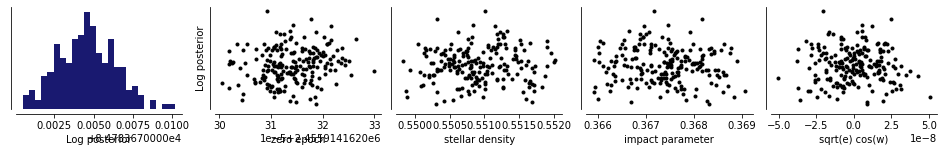

In [8]:
how_to_start = 'start_from_scratch'
#how_to_start = 'continue'
npop = 200

if how_to_start is 'start_from_scratch':
    lpf.optimize_global(45000, npop, pool=pool, lnpost=lnposterior, vectorize=False)
    lpf.sample_mcmc(50, thin=10, repeats=1, save=False, pool=pool, lnpost=lnposterior, vectorize=False)
    
elif how_to_start is 'continue':
    lpf.optimize_global(1, 200, pool=pool, lnpost=lnposterior, vectorize=False)
    df = read_mcmc(f'results/{lpf.name}.nc')
    sids = permutation(df.values.shape[0])[:lpf.de.n_pop]
    starting_population = df.values[sids, :-1].copy()
    lpf.sample_mcmc(50, thin=10, repeats=1, save=False, population=starting_population, 
                    pool=pool, lnpost=lnposterior, vectorize=False)
    
else:
    raise NotImplementedError

## Sample the posterior

As mentioned above, this will take from six to eight hours with a relatively powerful computer, so better just leave it running over night.

In [ ]:
lpf.sample_mcmc(5000, thin=50, repeats=10, save=True, pool=pool, lnpost=lnposterior, vectorize=False)

---

<center>&copy 2022 Hannu Parviainen</center>